In [1]:
import pandas as pd
import re
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Read the Excel file
df = pd.read_excel("E:\城市租房数据（贝壳链家）2024年\上海贝壳合并2411.xlsx", sheet_name="Sheet1")

# df.info()

In [2]:
df = df.replace("暂无数据", np.nan).dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7396 entries, 18 to 34126
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   标题      7396 non-null   object
 1   维护时间    7396 non-null   object
 2   租金      7396 non-null   object
 3   标签      7396 non-null   object
 4   租赁方式    7396 non-null   object
 5   房屋类型    7396 non-null   object
 6   面积      7396 non-null   object
 7   楼层      7396 non-null   object
 8   车位      7396 non-null   object
 9   用电      7396 non-null   object
 10  采暖      7396 non-null   object
 11  朝向      7396 non-null   object
 12  电梯      7396 non-null   object
 13  用水      7396 non-null   object
 14  燃气      7396 non-null   object
 15  配套设置    7396 non-null   object
dtypes: object(16)
memory usage: 982.3+ KB


In [3]:
df.duplicated().sum()# Count duplicate entries
df.drop_duplicates(inplace=True)# Remove duplicate entries

In [4]:
# ----------------------------
# 1. Extract district (example logic, needs actual district names)
def extract_community(title):
    """
    从标题中提取小区名称，格式为 `整租/合租·小区名 户型...`
    示例：
    输入：整租·慧芝湖花园（三期） 1室2厅 南 → 输出：慧芝湖花园（三期）
    输入：合租·君御豪庭 3室2厅 南/北 → 输出：君御豪庭
    """
    if pd.isna(title):
        return None
    
    # Split rental type and community part (using "·" as separator)
    if "·" in title:
        parts = title.split("·", 1)  # Split into two parts
        community_part = parts[1].strip()
    else:
        # Handle cases with no separator (e.g., title is "Whole Rent Jing'an City 1BR1LR South")
        for prefix in ["整租", "合租"]:
            if title.startswith(prefix):
                community_part = title[len(prefix):].strip()
                break
        else:
            return None  # Unrecognized format
    
    # Extract community name (remove following layout info, assuming it starts with a digit)
    community = community_part.split()[0]
    return community

# Add a new column for community name
df["位置"] = df["标题"].apply(extract_community)

# Extract numeric values for rent and area
df['租金'] = df['租金'].str.extract('(\d+)').astype(int)
df['面积'] = df['面积'].str.extract('([\d.]+)').astype(float)

# Clean up facility column by removing special characters and joining with single spaces
df['配套设置'] = df['配套设置'].str.replace('_x000d_', '', regex=True).str.split().str.join(' ')
df['配套设置'] = df['配套设置'].str.replace('_x005f', '', regex=True).str.split().str.join(' ')
# ----------------------------
# 2. Detect subway and balcony presence
# ----------------------------
# Split tags and check for keywords
def check_subway(tags):
    if pd.isna(tags):
        return 0
    return 1 if "近地铁" in tags else 0

def check_balcony(tags):
    if pd.isna(tags):
        return 0
    return 1 if "独立阳台" in tags or "阳台" in tags else 0

df["地铁"] = df["标签"].apply(check_subway)
df["阳台"] = df["标签"].apply(check_balcony)

# Encode rental type
df["租赁方式"] = df["租赁方式"].map({"整租": 1, "合租": 0})

# Split and classify floor level
def classify_floor(floor_str):
    # Handle cases like "middle floor/31 floors"
    if "低楼层" in floor_str:
        return 1  # Low floor = 1
    elif "中楼层" in floor_str:
        return 2  # Middle floor = 2
    elif "高楼层" in floor_str:
        return 3  # High floor = 3
    # Handle numeric formats like "4/6 floors"
    elif "/" in floor_str:
        current_floor, total_floor = map(int, floor_str.replace("层", "").split("/"))
        ratio = current_floor / total_floor
        if ratio <= 0.3:
            return 1  # Low floor
        elif 0.3 < ratio < 0.7:
            return 2  # Middle floor
        else:
            return 3  # High floor
    else:
        return np.nan  # Mark abnormal data as missing

# Extract floor level type and total floors
df["楼层类型"] = df["楼层"].apply(classify_floor)
# Drop original floor column
df = df.drop(columns=["楼层"])
# Binary encoding (yes = 1, no = 0)
df["电梯"] = df["电梯"].map({"有": 1, "无": 0})
# Method 1: map directly to binary
df['用电_编码'] = df['用电'].map({'民电': 0, '商电': 1})
df['采暖_编码'] = df['采暖'].map({'自采暖': 0, '集中供暖': 1})

# ----------------------------
# 3. Extract layout and decoration info
# ----------------------------
# Extract layout info using regex (e.g., x室x厅x卫)
def extract_layout(house_type):
    if pd.isna(house_type):
        return None
    match = re.search(r"\d+室\d+厅\d+卫", house_type)
    return match.group() if match else None

# Check if the house is finely decorated
def check_renovation(house_type):
    if pd.isna(house_type):
        return 0
    return 1 if "精装修" in house_type else 0

df["房屋户型"] = df["房屋类型"].apply(extract_layout)
df["房屋装修"] = df["房屋类型"].apply(check_renovation)

# Extract number of bedrooms, living rooms, and bathrooms
df["室"] = df["房屋户型"].str.extract(r"(\d+)室").astype(int)
df["厅"] = df["房屋户型"].str.extract(r"(\d+)厅").astype(int)
df["卫"] = df["房屋户型"].str.extract(r"(\d+)卫").astype(int)
# Drop original layout column
df = df.drop(columns=["房屋户型"])

# Drop unnecessary columns
df = df.drop(columns=['标题', '标签', '房屋类型', '车位','用水','燃气','用电','采暖'])

# ----------------------------
df

,维护时间,租金,租赁方式,面积,朝向,电梯,配套设置,位置,地铁,阳台,楼层类型,用电_编码,采暖_编码,房屋装修,室,厅,卫
18,2024-11-13,16000,1,170.00,南,1,洗衣机 空调 衣柜 电视 冰箱 热水器,中海万锦城(三期),1,0,2,0,0,1,3,2,2
20,2024-11-08,52000,1,223.47,南,1,洗衣机 空调 衣柜 电视 冰箱 热水器 床 天然气,中粮天悦壹号,1,0,1,0,0,1,4,2,4
23,2024-11-10,17500,1,140.76,南,1,洗衣机 空调 衣柜 电视 冰箱 热水器 暖气 宽带 天然气,金柏苑,1,0,1,0,0,1,3,1,3
33,2024-11-09,11500,1,124.70,南,1,洗衣机 空调 衣柜 冰箱 热水器 床 天然气,新梅共和城,1,0,1,0,0,0,3,2,2
35,2024-11-13,3600,1,24.45,西,1,洗衣机 空调 衣柜 电视 冰箱 热水器 床,蓝朝部落,1,0,1,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34062,2024-11-15,8700,1,98.67,南,1,洗衣机 空调 衣柜 冰箱 热水器 床 暖气 天然气,中骏天珑,0,0,2,0,0,1,3,2,2
34066,2024-11-13,9500,1,96.93,南,0,洗衣机 空调 衣柜 电视 冰箱 热水器 暖气 宽带 天然气,中国铁建花语江南,0,0,2,0,0,1,3,2,2
34080,2024-11-15,3800,1,79.86,南 北,0,洗衣机 空调 衣柜 电视 冰箱 热水器 床,新丰公寓,0,0,3,0,0,0,2,2,1
34089,2024-11-13,4100,1,84.23,南,1,洗衣机 空调 衣柜 电视 冰箱 热水器 床 天然气,新丰公寓,0,0,3,0,0,1,2,1,1


In [5]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoders
le_orientation = LabelEncoder()
le_rental = LabelEncoder()

# Encode "orientation" and "location"
df["朝向_编码"] = le_orientation.fit_transform(df["朝向"])
df["位置_编码"] = le_rental.fit_transform(df["位置"])
df = df.drop(columns=["朝向", "位置"])

In [6]:
# Convert maintenance time to datetime type
df["维护时间"] = pd.to_datetime(df["维护时间"])

# Convert to timestamp (float type)
df["维护时间_时间戳"] = df["维护时间"].astype("int64") // 10**9  # 转换为秒级时间戳
df["维护时间_时间戳"] = df["维护时间_时间戳"].astype("float64")
# Drop original datetime column
df = df.drop("维护时间", axis=1)

In [7]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Unify "bed + natural gas" and "bed + gas" into "bed" and "gas"
df["配套设置"] = df["配套设置"].str.replace("床天然气", "床 天然气")
# Generate binary variables for selected facilities
facilities = ["洗衣机", "空调", "衣柜", "电视", "冰箱", "热水器", "床", "天然气"]
for facility in facilities:
    df[f"设施_{facility}"] = df["配套设置"].apply(lambda x: 1 if facility in x else 0)

# 3. Generate statistical features for total facilities
df["配套设置数量"] = df["配套设置"].apply(len)

# 4. Separate features and target variable
X = df.drop(columns=["租金", "配套设置"])  # Feature matrix (including binary and statistical features)
y = df["租金"]  # Target variable
# Drop the original facility column
df = df.drop("配套设置", axis=1)


In [8]:
df

,租金,租赁方式,面积,电梯,地铁,阳台,楼层类型,用电_编码,采暖_编码,房屋装修,...,维护时间_时间戳,设施_洗衣机,设施_空调,设施_衣柜,设施_电视,设施_冰箱,设施_热水器,设施_床,设施_天然气,配套设置数量
18,16000,1,170.00,1,1,0,2,0,0,1,...,1.731456e+09,1,1,1,1,1,1,0,0,19
20,52000,1,223.47,1,1,0,1,0,0,1,...,1.731024e+09,1,1,1,1,1,1,1,1,25
23,17500,1,140.76,1,1,0,1,0,0,1,...,1.731197e+09,1,1,1,1,1,1,0,1,29
33,11500,1,124.70,1,1,0,1,0,0,0,...,1.731110e+09,1,1,1,0,1,1,1,1,22
35,3600,1,24.45,1,1,0,1,0,0,1,...,1.731456e+09,1,1,1,1,1,1,1,0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34062,8700,1,98.67,1,0,0,2,0,0,1,...,1.731629e+09,1,1,1,0,1,1,1,1,25
34066,9500,1,96.93,0,0,0,2,0,0,1,...,1.731456e+09,1,1,1,1,1,1,0,1,29
34080,3800,1,79.86,0,0,0,3,0,0,0,...,1.731629e+09,1,1,1,1,1,1,1,0,21
34089,4100,1,84.23,1,0,0,3,0,0,1,...,1.731456e+09,1,1,1,1,1,1,1,1,25


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6732 entries, 18 to 34126
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   租金        6732 non-null   int32  
 1   租赁方式      6732 non-null   int64  
 2   面积        6732 non-null   float64
 3   电梯        6732 non-null   int64  
 4   地铁        6732 non-null   int64  
 5   阳台        6732 non-null   int64  
 6   楼层类型      6732 non-null   int64  
 7   用电_编码     6732 non-null   int64  
 8   采暖_编码     6732 non-null   int64  
 9   房屋装修      6732 non-null   int64  
 10  室         6732 non-null   int32  
 11  厅         6732 non-null   int32  
 12  卫         6732 non-null   int32  
 13  朝向_编码     6732 non-null   int32  
 14  位置_编码     6732 non-null   int32  
 15  维护时间_时间戳  6732 non-null   float64
 16  设施_洗衣机    6732 non-null   int64  
 17  设施_空调     6732 non-null   int64  
 18  设施_衣柜     6732 non-null   int64  
 19  设施_电视     6732 non-null   int64  
 20  设施_冰箱     6732 non-null   int64  

In [10]:
# Define mapping dictionary for Chinese-English column names
column_mapping = {
    # Basic information
    '维护时间_时间戳': 'Maintenance_Date',
    '租金': 'Rent',
    '租赁方式': 'Rental_Type',
    '面积': 'Area',
    '电梯': 'Elevator',
    '位置_编码': 'Location',
    '朝向_编码': 'Toward',
    '地铁': 'Subway',
    '阳台': 'Balcony',
    
    # Floor-related
    '楼层类型': 'Floor_Type',
    
    # Energy-related
    '用电_编码': 'Electricity',
    '采暖_编码': 'Heating',
    
    # Facility-related
    '设施_洗衣机': 'Facility_Washing_Machine',
    '设施_空调': 'Facility_Air_Conditioner',
    '设施_衣柜': 'Facility_Wardrobe',
    '设施_电视': 'Facility_TV',
    '设施_冰箱': 'Facility_Refrigerator',
    '设施_热水器': 'Facility_Water_Heater',
    '设施_床': 'Facility_Bed',
    '设施_天然气': 'Facility_Natural_Gas',
    '配套设置数量': 'Facility_num',
    
    # House information
    '房屋装修': 'Renovation',
    '室': 'Bedroom_num',
    '厅': 'Living_Room_num',
    '卫': 'Bathroom_num'
}

# Rename columns
df = df.rename(columns=column_mapping)

# Save to Excel file
df.to_excel("processed_rental_data_sh.xlsx", index=False)


In [11]:
df.head()

,Rent,Rental_Type,Area,Elevator,Subway,Balcony,Floor_Type,Electricity,Heating,Renovation,...,Maintenance_Date,Facility_Washing_Machine,Facility_Air_Conditioner,Facility_Wardrobe,Facility_TV,Facility_Refrigerator,Facility_Water_Heater,Facility_Bed,Facility_Natural_Gas,Facility_num
18,16000,1,170.00,1,1,0,2,0,0,1,...,1.731456e+09,1,1,1,1,1,1,0,0,19
20,52000,1,223.47,1,1,0,1,0,0,1,...,1.731024e+09,1,1,1,1,1,1,1,1,25
23,17500,1,140.76,1,1,0,1,0,0,1,...,1.731197e+09,1,1,1,1,1,1,0,1,29
33,11500,1,124.70,1,1,0,1,0,0,0,...,1.731110e+09,1,1,1,0,1,1,1,1,22
35,3600,1,24.45,1,1,0,1,0,0,1,...,1.731456e+09,1,1,1,1,1,1,1,0,21


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rent,6732.0,7.583395e+03,9080.081483,5.000000e+02,2.748750e+03,5.000000e+03,8.300000e+03,1.700000e+05
Rental_Type,6732.0,7.459893e-01,0.435336,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Area,6732.0,7.738008e+01,67.215148,1.000000e+00,2.081500e+01,6.783000e+01,1.012275e+02,6.861300e+02
Elevator,6732.0,6.005645e-01,0.489819,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Subway,6732.0,5.129234e-01,0.499870,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Balcony,6732.0,7.011289e-02,0.255356,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Floor_Type,6732.0,2.077837e+00,0.799199,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00
Electricity,6732.0,6.179441e-02,0.240800,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Heating,6732.0,1.797386e-02,0.132866,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Renovation,6732.0,8.033274e-01,0.397512,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


## 可视化

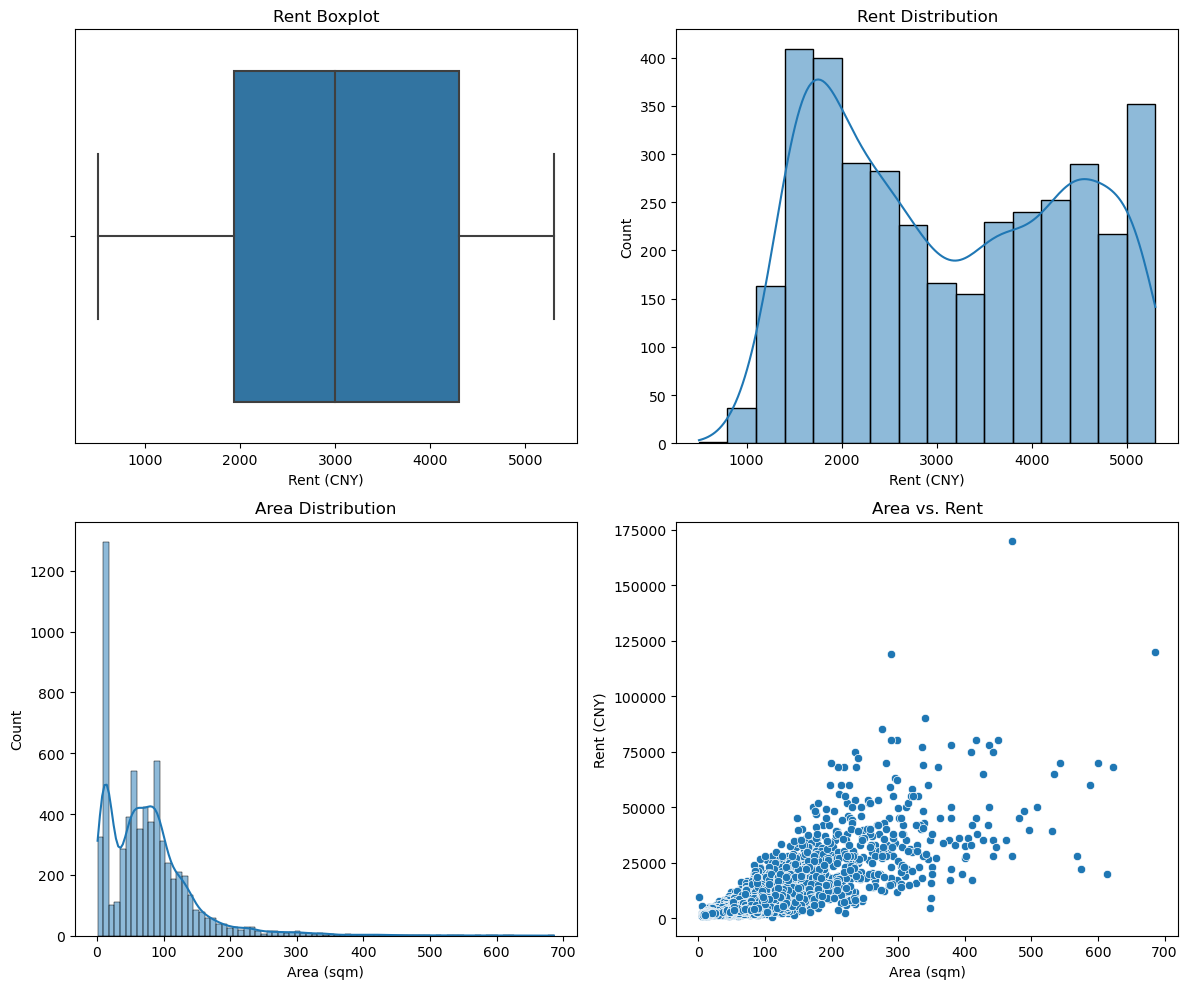

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute 55th percentile of rent to filter out extreme high values (used in the first two plots only)
rent_threshold = df['Rent'].quantile(0.55)
filtered_rent_df = df[df['Rent'] <= rent_threshold]

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Boxplot of rent (filtered)
sns.boxplot(data=filtered_rent_df, x='Rent', ax=axes[0, 0])
axes[0, 0].set_title('Rent Boxplot')
axes[0, 0].set_xlabel('Rent (CNY)')

# Plot 2: Histogram of rent distribution (filtered)
sns.histplot(data=filtered_rent_df, x='Rent', kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Rent Distribution')
axes[0, 1].set_xlabel('Rent (CNY)')
axes[0, 1].set_ylabel('Count')

# Plot 3: Histogram of area distribution (full data)
sns.histplot(data=df, x='Area', kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Area Distribution')
axes[1, 0].set_xlabel('Area (sqm)')
axes[1, 0].set_ylabel('Count')

# Plot 4: Scatter plot of area vs. rent (full data)
sns.scatterplot(x=df['Area'], y=df['Rent'], ax=axes[1, 1])
axes[1, 1].set_title('Area vs. Rent')
axes[1, 1].set_xlabel('Area (sqm)')
axes[1, 1].set_ylabel('Rent (CNY)')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


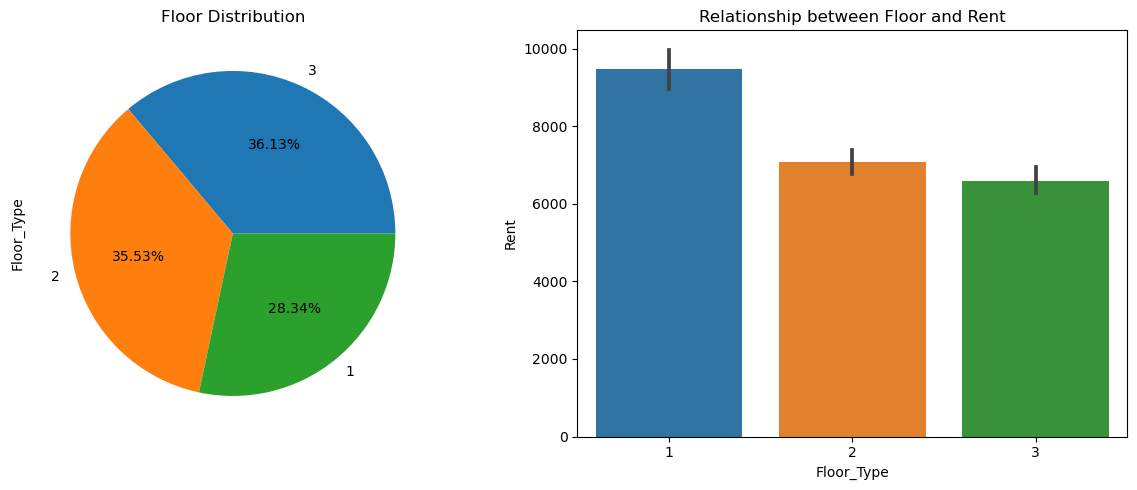

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 2x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# # Plot 1: Bar plot of House Orientation vs House Rent
# sns.barplot(data=df, x='House Orientation', y='Rent', ax=axes[0, 0])
# axes[0, 0].set_title('Relationship between House Orientation and Rent')

# Plot 2: Pie chart of Floor value counts
df['Floor_Type'].value_counts().plot(kind='pie', autopct='%.2f%%', ax=axes[0])
axes[0].set_title('Floor Distribution')

# Plot 3: Bar plot of Floor vs House Rent
sns.barplot(data=df, x='Floor_Type', y='Rent', ax=axes[1])
axes[1].set_title('Relationship between Floor and Rent')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

## 特征工程

In [27]:
# 5. Feature Importance Selection
# -------------------------------
# Method 1: Based on statistical test (ANOVA)
# -------------------------------
selector_anova = SelectKBest(score_func=f_classif, k=5)  # Select top 5 important features
X_selected_anova = selector_anova.fit_transform(X, y)

# Get names of selected features
selected_features_anova = X.columns[selector_anova.get_support()]
print("ANOVA筛选出的重要特征:", selected_features_anova.tolist())

ANOVA筛选出的重要特征: ['租赁方式', '面积', '室', '厅', '卫']


In [31]:
# Feature selection
# new_df = df[['Rent','Rental_Type','Area','Bedroom_num','Living_Room_num','Bathroom_num']]
new_df = df[['Maintenance_Date','Rent','Rental_Type', 'Area','Elevator', 'Location','Toward','Subway','Balcony','Floor_Type','Electricity',
'Heating','Facility_Washing_Machine', 'Facility_Air_Conditioner','Facility_Wardrobe','Facility_TV','Facility_Refrigerator','Facility_Water_Heater','Facility_Bed',
'Facility_Natural_Gas','Facility_num', 'Renovation', 'Bedroom_num','Living_Room_num','Bathroom_num']]

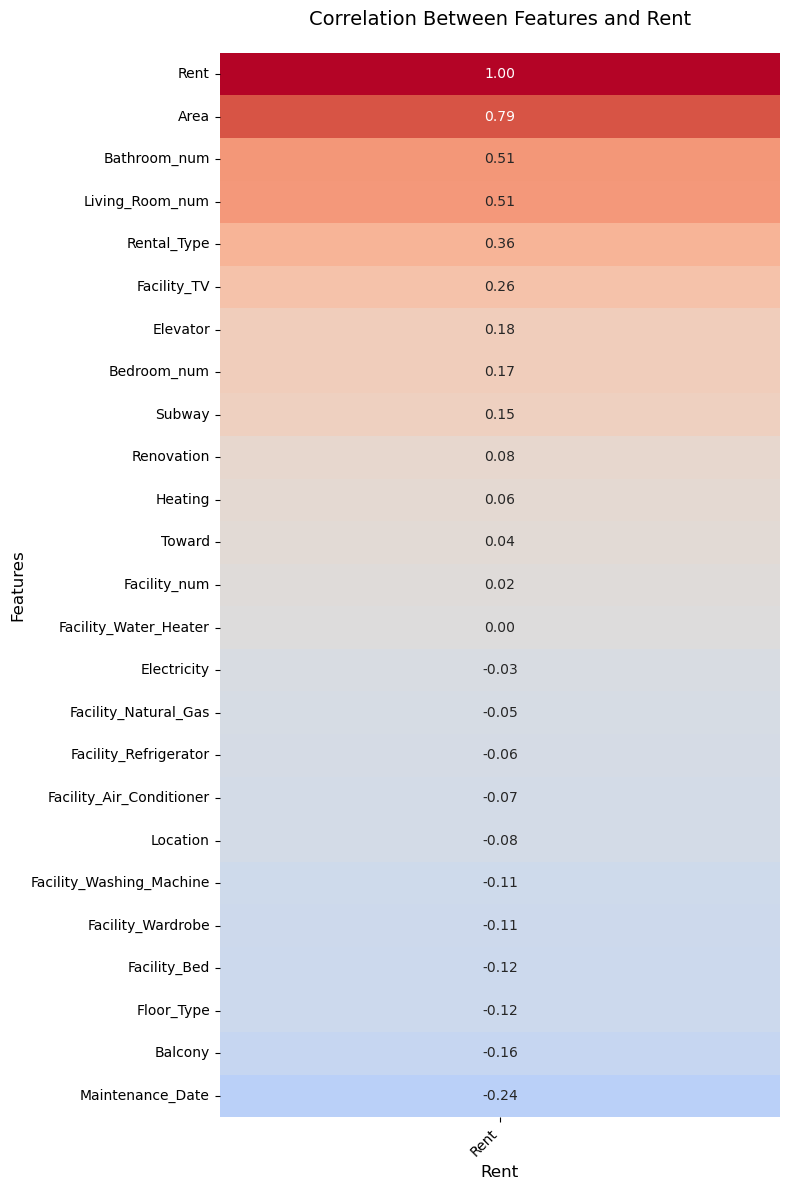

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation between all features and Rent
correlation = new_df.corr()[["Rent"]].sort_values(by="Rent", ascending=False)

# Set figure size and style for heatmap
plt.figure(figsize=(8, 12))  # Increase height to fit more rows
sns.heatmap(
    correlation,  # Use the sorted correlation data directly
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10},  # Increase annotation font size
    cbar=False,  # Remove color bar to save space
    vmin=-1,
    vmax=1
)

# Optimize label display
plt.title("Correlation Between Features and Rent", fontsize=14, pad=20)
plt.xlabel("Rent", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels
plt.yticks(rotation=0)  # Keep y-axis labels horizontal

# Automatically adjust layout to prevent clipping
plt.tight_layout()
plt.show()


In [41]:
# Load the data file and process the data
# df = new_df[['Rent','Rental_Type', 'Area','Elevator','Subway','Facility_TV',
#  'Bedroom_num','Living_Room_num','Bathroom_num']]
df = new_df[['Maintenance_Date','Rent','Rental_Type', 'Area','Elevator', 'Location','Toward','Subway','Balcony','Floor_Type','Electricity',
'Heating','Facility_Washing_Machine', 'Facility_Air_Conditioner','Facility_Wardrobe','Facility_TV','Facility_Refrigerator','Facility_Water_Heater','Facility_Bed',
'Facility_Natural_Gas','Facility_num', 'Renovation', 'Bedroom_num','Living_Room_num','Bathroom_num']]

## 多重线性回归模型

In [46]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.tools import add_constant
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
# Split independent variables (X) and dependent variable (y)
X = df.drop('Rent', axis=1)
y = df['Rent']

# Split training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Take the required feature columns and standardize them
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_const = add_constant(X_train_scaled)
X_test_const = add_constant(X_test_scaled)

model = sm.OLS(y_train, X_train_const).fit()

# Calculate Mean Squared Error (MSE)
y_pred = model.predict(X_test_const)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("测试集上 OLS 模型均方误差 (MSE)：", mse)
print("测试集上 OLS 模型平均绝对误差 (MAE)：", mae)
print("测试集上 OLS 模型决定系数 (R2)：", r2)

测试集上 OLS 模型均方误差 (MSE)： 25096091.64350616
测试集上 OLS 模型平均绝对误差 (MAE)： 2706.7028673696195
测试集上 OLS 模型决定系数 (R2)： 0.7117111311539346


## ridge回归

In [47]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ============ 1. Prepare Data ============
# Assuming the original DataFrame is called df
# Make sure that 'Rent' is your target column name and do not include it in the features
X = df.drop(columns=['Rent'])   # Remove target column
y = df['Rent']

# ============ 2. Split Training and Test Sets ============
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# ============ 3. Standardize Features ============
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform on training set
X_test_scaled = scaler.transform(X_test)        # Transform test set using training set's parameters

# ============ 4. Grid Search for Hyperparameter alpha ============
ridge = Ridge()  # No need to manually add_constant, Ridge includes intercept by default
params = {
    'alpha': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1000]
}

grid_model = GridSearchCV(ridge, params, cv=5, scoring='r2')
grid_model.fit(X_train_scaled, y_train)

print("Best CV Score (on training folds):", grid_model.best_score_)
print("Best Params:", grid_model.best_params_)

# ============ 5. Retrain on Training Set with Best alpha ============
best_alpha = grid_model.best_params_['alpha']
reg = Ridge(alpha=best_alpha)
reg.fit(X_train_scaled, y_train)

# ============ 6. Predict and Evaluate on Test Set ============
y_pred = reg.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Ridge模型均方误差 (MSE)：", mse)
print("Ridge模型平均绝对误差 (MAE)：", mae)
print("Ridge模型决定系数 (R2)：", r2)


Best CV Score (on training folds): 0.701290868686107
Best Params: {'alpha': 10}
Ridge模型均方误差 (MSE)： 25121829.06877066
Ridge模型平均绝对误差 (MAE)： 2705.3706082402373
Ridge模型决定系数 (R2)： 0.7114154750285939


## 决策树回归

In [49]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)# 忽略 DeprecationWarning 警告
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming df is your complete data, where 'Rent' is the target column
# and features = df.drop(columns=['Rent']) is equivalent
X = features  # your features
y = df['Rent']

# 1. First split training and test sets (if you have already split externally, this step can be skipped)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# 2. Define the parameter grid (remove overly extreme values or moderately shrink the range)
param_grid = {
    'max_depth': [3, 5, 10, 15, 20, None],    # None means no depth limit, but may overfit
    'min_samples_split': [2, 5, 10, 20, 30],  # removed min_samples_split=1 and other illegal/extreme values
    'min_samples_leaf': [1, 2, 5, 10],        # min_samples_leaf=1 is also prone to overfitting, but can be compared
    'max_features': [None, 'sqrt', 'log2']
}

# 3. Create a decision tree regression model
regressor = DecisionTreeRegressor(random_state=42)

# 4. Use GridSearchCV to find the best parameter combination (using 5-fold cross-validation on training set)
grid_search = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',  # could also use 'r2' etc.
    n_jobs=-1  # parallel acceleration, optional
)

# 5. Perform grid search on the training set
grid_search.fit(X_train, y_train)

# 6. Output the best parameter combination and the score in cross-validation
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best parameter combination:", best_params)

# 7. Use the model with the best parameter combination to predict on the test set
best_regressor = grid_search.best_estimator_
y_pred = best_regressor.predict(X_test)

# 8. Evaluate the model performance on the test set
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("决策回归树模型均方误差 (MSE):", mse)
print("决策回归树模型平均绝对误差 (MAE):", mae)
print("决策回归树模型R^2分数:", r2)

最佳参数组合: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
决策回归树模型均方误差 (MSE): 2068166.100037651
决策回归树模型平均绝对误差 (MAE): 320.2483372107052
决策回归树模型R^2分数: 0.9762421466244561


## lasso回归

In [48]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ============ 1. Ensure target column is not in features ============
# Assume df is your complete data, where 'Rent' is the target column
X = df.drop(columns=['Rent'])   # Remove target column, the rest are features
y = df['Rent']

# ============ 2. Split training and test sets ============
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# ============ 3. Use Pipeline to encapsulate "Standardization + Lasso" ============
pipeline = Pipeline([
    ('scaler', StandardScaler()),   # Step 1: Feature standardization
    ('lasso', Lasso())             # Step 2: Lasso regression
])

# ============ 4. Define hyperparameter space to search ============
params = {
    'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2, 5]
}

# ============ 5. Perform grid search (cross-validation) on training set ============
grid_model = GridSearchCV(
    estimator=pipeline, 
    param_grid=params, 
    cv=5,              # 5-fold cross-validation
    scoring='r2'
)
grid_model.fit(X_train, y_train)

print("Best CV Score (on training folds):", grid_model.best_score_)
print("Best Params:", grid_model.best_params_)

# ============ 6. Evaluate on test set using best parameter model ============
best_model = grid_model.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Lasso回归模型均方误差 (MSE)：", mse)
print("Lasso回归模型平均绝对误差 (MAE)：", mae)
print("Lasso回归模型决定系数 (R2)：", r2)


Best CV Score (on training folds): 0.7012836485761473
Best Params: {'lasso__alpha': 5}
Lasso回归模型均方误差 (MSE)： 25146941.915148117
Lasso回归模型平均绝对误差 (MAE)： 2703.90754070063
Lasso回归模型决定系数 (R2)： 0.7111269936914


## 随机森林

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assume df is your complete data, where 'Rent' is the target column
# and features = df.drop(columns=['Rent']) is equivalent
X = features
y = df['Rent']

# 1. First split training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# 2. Create random forest model (can enable oob_score=True for out-of-bag evaluation)
rf_model = RandomForestRegressor(
    oob_score=True, 
    random_state=42
)

# 3. Create hyperparameter dictionary (moderately narrow range to avoid overfitting)
params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],         # originally had 10, 15; can try removing overly large values
    'min_samples_split': [5, 10, 20], # avoid too small values (like 2) that may make trees too deep
    'min_samples_leaf': [2, 4, 5]     # increase min_samples_leaf to suppress overfitting
}

# 4. Create grid search model (perform 5-fold cross-validation on training set)
grid_model = GridSearchCV(
    estimator=rf_model,
    param_grid=params,
    cv=5, 
    scoring='r2',
    n_jobs=-1  # parallel acceleration, optional
)

# 5. Fit the model to training data
grid_model.fit(X_train, y_train)

# 6. Print best hyperparameters and corresponding R^2 score (based on training set cross-validation)
print("Best CV Score:", grid_model.best_score_)
print("Best Params:", grid_model.best_params_)

# 7. Create final model with best hyperparameters and train on training set
best_params = grid_model.best_params_
rf_reg = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    oob_score=True,
    random_state=42
)

rf_reg.fit(X_train, y_train)

# 8. Predict and evaluate model performance on "test set"
y_pred = rf_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("随机森林模型均方误差 (MSE):", mse)
print("随机森林模型平均绝对误差 (MAE):", mae)
print("随机森林模型R^2分数:", r2)



Best CV Score: 0.9836106977264327
Best Params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
随机森林模型均方误差 (MSE): 13318.199119392813
随机森林模型平均绝对误差 (MAE): 14.361734309088563
随机森林模型R^2分数: 0.999847008505797
